Matt Dwyer

mdd328

In [1]:
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.mixture import GaussianMixture
from scipy import linalg
import matplotlib as mpl

### Q1 (15 points) 

#### This question is to be solved by hand.

Given the following learned Bayesian network structure explaining the relationships between variables in container shipping data:

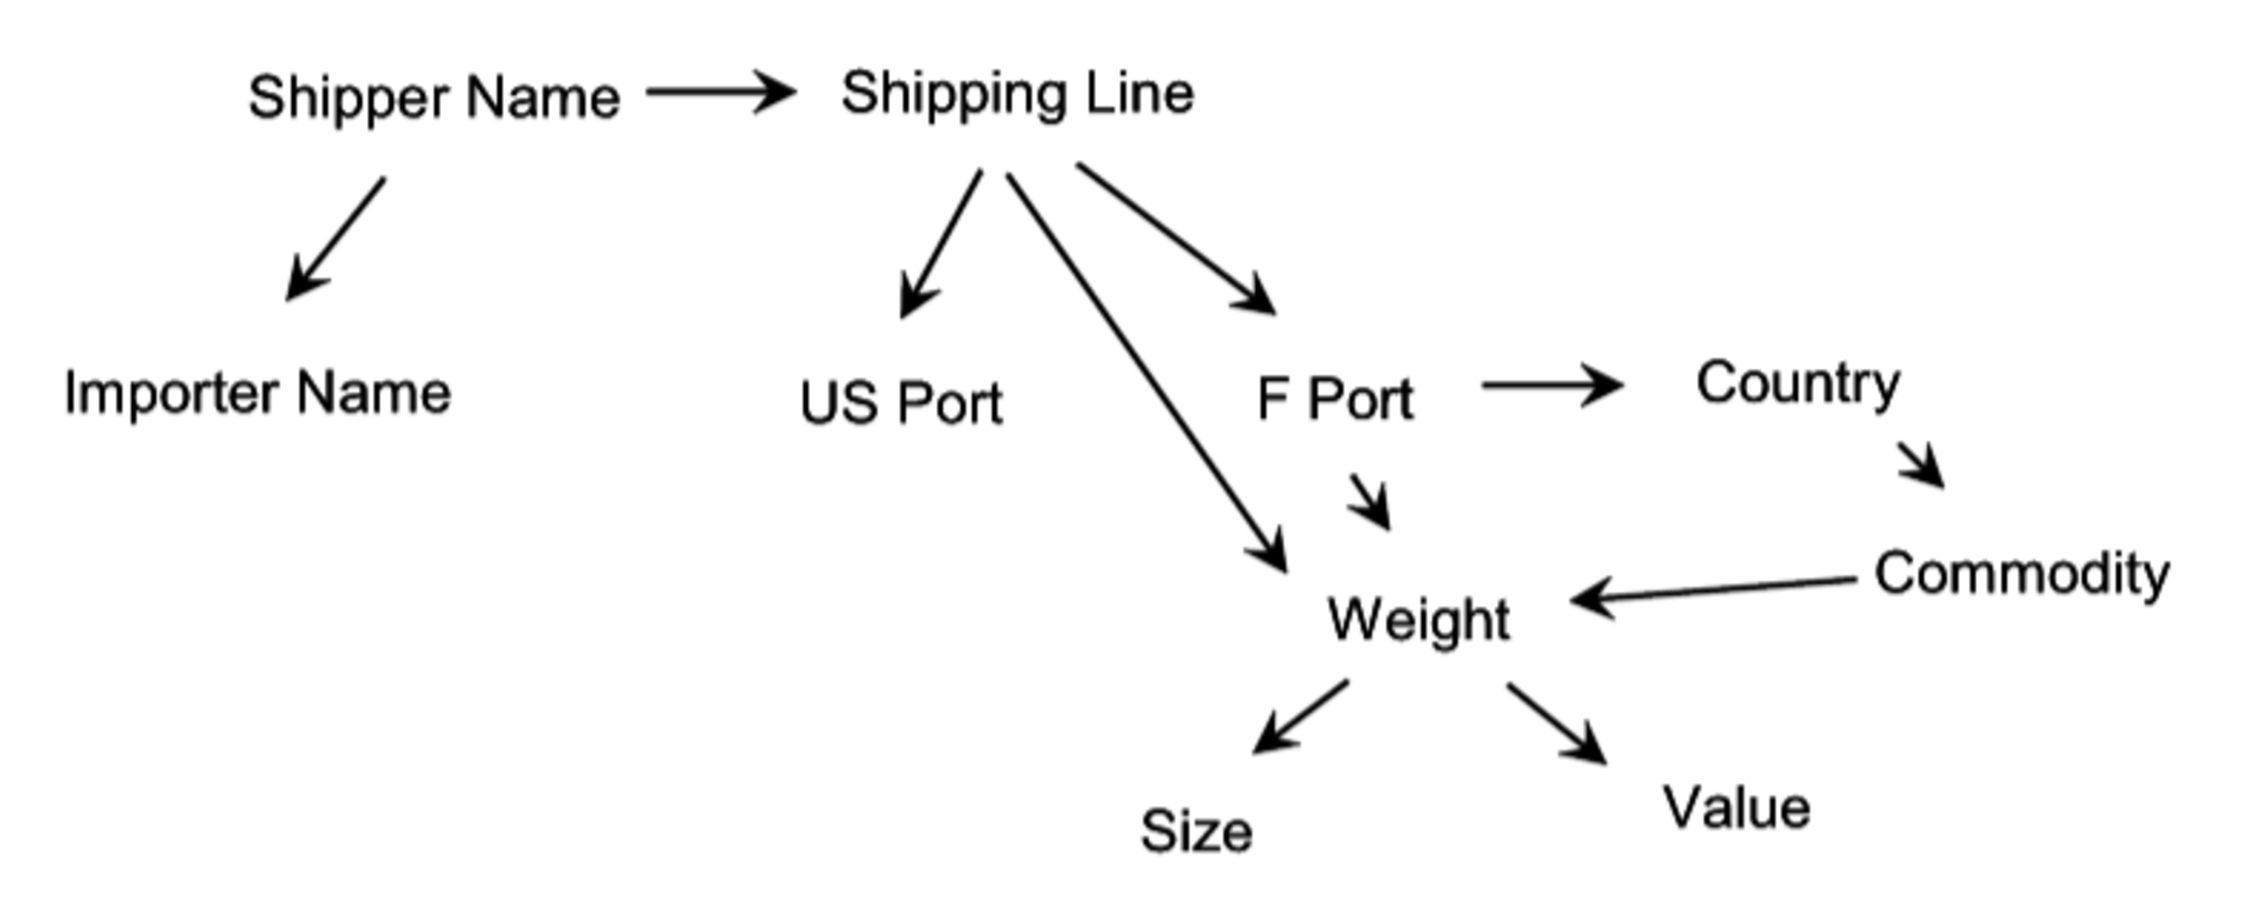

In [2]:
Image('HW3Q1.png')

1) Which of the following conditional independence relationships hold? Choose “Independent” or “Dependent” for each (6 points):

CI (Shipper Name, Value | F Port)? Dependent

CI (Shipper Name, Value | Shipping Line)? Independent

CI (Foreign Port, Commodity | Country)? Independent

CI (Foreign Port, Commodity | Country, Weight)? Dependent

2) Now consider a smaller dataset with only four discrete attributes (Shipping Line, US Port, Foreign Port, Weight), and the following conditional probability distributions:

Shipping Line: CSCO (70%), ASCO (30%)

Foreign Port | Shipping Line = CSCO: Yokohama (40%), Vancouver (60%)

Foreign Port | Shipping Line = ASCO: Vancouver (100%)

US Port | Shipping Line = ASCO: Seattle (100%)

US Port | Shipping Line = CSCO: Seattle (80%), Los Angeles (20%)

Weight | Shipping Line = ASCO, Foreign Port = Vancouver: Light (30%), Medium (50%), Heavy (20%)

Weight | Shipping Line = CSCO, Foreign Port = Vancouver: Light (15%), Medium (70%), Heavy (15%)

Weight | Shipping Line = CSCO, Foreign Port = Yokohama: Light (10%), Medium (30%), Heavy (60%)

Which of the following packages is most anomalous?

a) A heavy package shipped from Vancouver to Seattle by ASCO

b) A heavy package shipped from Vancouver to Seattle by CSCO

c) A heavy package shipped from Yokohama to Los Angeles by CSCO

To answer this question, compute the likelihood of each package given the Bayesian Network (lowest likelihood = most anomalous). You must show your calculations to receive credit. (9 points)

In [3]:
# a) Shipping Line: ASCO (30%) * Foreign Port: Vancouver (100%) * US Port: Seattle (100%) * Weight: Heavy (20%)
.3 * 1 * 1 * .2

0.06

In [4]:
# b) Shipping Line: CSCO (70%) * Foreign Port: Vancouver (60%) * US Port: Seattle (80%) * Weight: Heavy (15%)
.7 * .6 * .8 * .15

0.0504

In [5]:
# c) Shipping Line: CSCO (70%) * Foreign Port: Yokohama (40%) * US Port: Los Angeles (20%) * Weight: Heavy (60%)
.7 * .4 * .2 * .6

0.0336

Choice c) "A heavy package shipped from Yokohama to Los Angeles by CSCO" is the most anomalous

### Q2. Bayesian Network Learning (35 points)

In this question, we use dataset: "HW3Q2.csv" for Bayesian Network Learning.

In [6]:
from sklearn.model_selection import train_test_split
data2=pd.read_csv("HW3Q2.csv")
train,test=train_test_split(data2,random_state=9,test_size=0.4)
data2.head()

,A,B,C,D,E,F
0,1,0,0,0,1,1
1,2,0,0,1,0,1
2,3,1,0,1,1,1
3,2,0,0,1,1,1
4,1,0,1,0,1,1


a) Use the training data to select the best structure you want to use for Bayesian Network Learning. Please use Hill Climbing with BIC score metric. (10 points)

In [10]:
from pgmpy.estimators import HillClimbSearch, BicScore, BayesianEstimator
np.random.seed(123)
hc = HillClimbSearch(train, scoring_method=BicScore(train))
best_model = hc.estimate()
print(best_model.edges())

[('C', 'D'), ('B', 'A'), ('D', 'E'), ('F', 'C'), ('F', 'B')]


b) Use the Bayesian Estimator to estimate the CPDs for your model and visualize the network with CPDs. (15 points)

In [11]:
best_model.fit(train, estimator=BayesianEstimator, prior_type='K2')
for cpd in best_model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)

CPD of A:
+------+------+------+
| B    | B(0) | B(1) |
+------+------+------+
| A(0) | 0.2  | 0.2  |
+------+------+------+
| A(1) | 0.2  | 0.2  |
+------+------+------+
| A(2) | 0.2  | 0.2  |
+------+------+------+
| A(3) | 0.2  | 0.2  |
+------+------+------+
| A(4) | 0.2  | 0.2  |
+------+------+------+
CPD of C:
+------+------+------+
| F    | F(0) | F(1) |
+------+------+------+
| C(0) | 0.5  | 0.5  |
+------+------+------+
| C(1) | 0.5  | 0.5  |
+------+------+------+
CPD of B:
+------+------+------+
| F    | F(0) | F(1) |
+------+------+------+
| B(0) | 0.5  | 0.5  |
+------+------+------+
| B(1) | 0.5  | 0.5  |
+------+------+------+
CPD of E:
+------+------+------+
| D    | D(0) | D(1) |
+------+------+------+
| E(0) | 0.5  | 0.5  |
+------+------+------+
| E(1) | 0.5  | 0.5  |
+------+------+------+
CPD of D:
+------+------+------+
| C    | C(0) | C(1) |
+------+------+------+
| D(0) | 0.5  | 0.5  |
+------+------+------+
| D(1) | 0.5  | 0.5  |
+------+------+------+
CPD of 

c) Use the model to predict "A" for the testing dataset. Report the out-of-sample prediction accuracy. (10 points)   

In [12]:
predicted_test = best_model.predict(test.loc[:,"B":"F"])
print "Out of sample:",(test.loc[:,'A']==predicted_test['A']).mean()

Out of sample: 0.0695


### Q3. Clustering: Spatial and Temporal Distributions of Chicago Crimes (50 points)

In this question you will use k-means and Gaussian mixture clustering in sklearn and hierarchical clustering in scipy to answer the question, “Do different types of crime display different trends over space and time?”  The dataset “HW3Q3_1.csv” consists of data for 119 different types of crime, each of which occurred at least 100 times in Chicago during the year 2016.  For each crime type, we have various features representing the spatial and temporal distribution of crime, including:

- The proportion of all crimes of that type that occurred on each day of the week (day_Sun, day_Mon, …, day_Sat).

- The proportion of all crimes of that type that occurred on each hour of the day (hour_0 = midnight to 12:59am, hour_1 = 1am to 1:59am, …, hour_23 = 11pm to 11:59pm).

- The proportion of all crime of that type that occurred in each of the 77 community areas of Chicago (community_area_1 … community_area_77).

We also have, for each crime type, its categorization by the FBI:

- Category = “P1V” corresponds to Part 1 Violent Crime, i.e., serious violent crimes

- Category = “P1P” corresponds to Part 1 Property Crime, i.e., serious property crimes

- Category = “P2” corresponds to Part 2 (less serious) crimes.

To answer parts a through f, you should cluster the 119 crime types using k-means into k = 3 clusters using only the hour of day (hour_0..hour_23) attributes.

In [13]:
data3=pd.read_csv("HW3Q3_1.csv")
data3.head()

,crime_type,Category,day_Sun,day_Mon,day_Tue,day_Wed,day_Thu,day_Fri,day_Sat,hour_0,...,community_area_68,community_area_69,community_area_70,community_area_71,community_area_72,community_area_73,community_area_74,community_area_75,community_area_76,community_area_77
0,ARSON: BY FIRE,P1P,0.138810,0.135977,0.155807,0.121813,0.130312,0.147309,0.169972,0.073654,...,0.019830,0.016997,0.019830,0.022663,0.005666,0.000000,0.002833,0.005666,0.000000,0.002833
1,ASSAULT: AGG PO HANDS NO/MIN INJURY,P2,0.151852,0.118519,0.162963,0.122222,0.129630,0.129630,0.185185,0.055556,...,0.037037,0.048148,0.018519,0.025926,0.003704,0.003704,0.003704,0.011111,0.011111,0.007407
2,ASSAULT: AGGRAVATED: HANDGUN,P1V,0.149912,0.139405,0.141506,0.131349,0.136953,0.133100,0.167776,0.040630,...,0.035377,0.031524,0.013310,0.042732,0.002102,0.017863,0.000000,0.012259,0.002102,0.003152
3,ASSAULT: AGGRAVATED: OTHER DANG WEAPON,P1V,0.125000,0.139000,0.148000,0.153000,0.133000,0.142000,0.160000,0.034000,...,0.028000,0.030000,0.014000,0.037000,0.003000,0.010000,0.002000,0.002000,0.003000,0.006000
4,ASSAULT: AGGRAVATED: OTHER FIREARM,P1V,0.156863,0.107843,0.166667,0.117647,0.147059,0.117647,0.186275,0.009804,...,0.029412,0.019608,0.009804,0.019608,0.000000,0.000000,0.000000,0.009804,0.000000,0.000000


In [14]:
data4=pd.read_csv("HW3Q3_2.csv")
data4.head()

,Community Area Number,COMMUNITY AREA NAME,centroid_x,centroid_y,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,PERCENT OF HOUSING UNITS VACANT,NUM_CRIMES_2016
0,1,Rogers Park,1164399.219,1947666.815,7.7,23.6,8.7,18.2,27.5,23939,11.870556,3420
1,2,West Ridge,1158307.200,1943243.722,7.8,17.2,8.8,20.8,38.5,23040,9.870385,3068
2,3,Uptown,1168228.082,1930980.022,3.8,24.0,8.9,11.8,22.2,35787,8.672137,3330
3,4,Lincoln Square,1159618.804,1933105.743,3.4,10.9,8.2,13.4,25.5,37524,8.600422,1859
4,5,North Center,1161104.228,1924056.010,0.3,7.5,5.2,4.5,26.2,57123,10.100636,1280


In [85]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3)
X = data3.loc[:,'hour_0':'hour_23']
res = km.fit(X)
data3_hrclusters = pd.concat([data3,pd.Series(res.predict(X))],axis=1)
#res=pd.concat((data3,pd.Series(res)),axis=1)
data3_hrclusters = data3_hrclusters.rename(columns={0: "hr_cluster"})
#print('With',3,'clusters, sum of squared errors is',km.inertia_,'\n')

a) Copy each cluster’s mean values for hour_0…hour_23 into a DataFrame and create a line graph to visualize these values by cluster.  (5 pts)

In [86]:
hr_avg = pd.DataFrame(res.cluster_centers_).T
hr_avg.head()

,0,1,2
0,0.058410,0.031053,0.055748
1,0.045807,0.019523,0.007016
2,0.041814,0.014750,0.006658
3,0.035348,0.011066,0.004915
4,0.027848,0.008954,0.007421


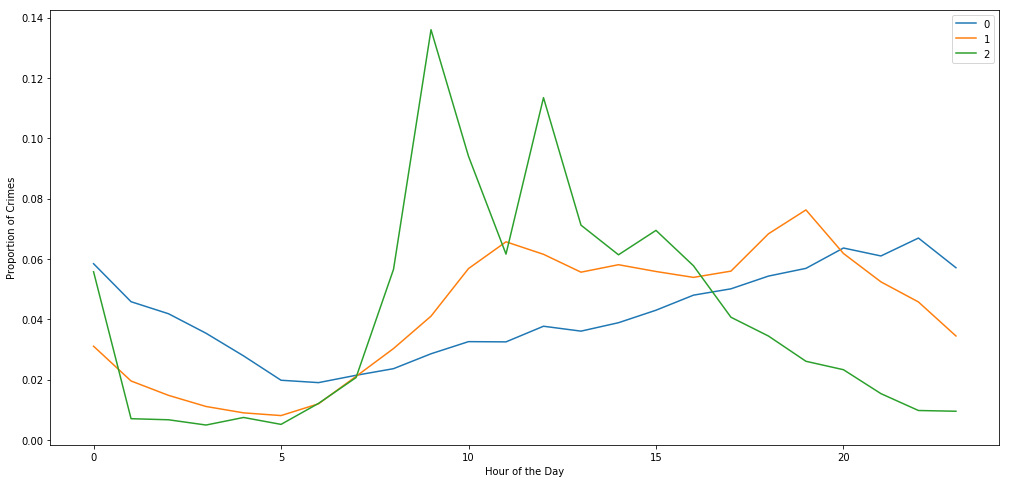

In [87]:
plt.figure(figsize = (17,8))
plt.plot(hr_avg)
plt.xlabel('Hour of the Day')
plt.ylabel('Proportion of Crimes')
plt.legend([0,1,2])
plt.show()

b) Describe the three different hour-of-day trends represented by these three clusters (5 pts).

Cluster 0 generally increases at night, increasing from 5 AM until it peaks around 10:00 PM. Cluster 1 is highest  during the day, peaking twice around 11 AM and 7 PM. Cluster 2 peaks sharply during work hours, around 9 AM and 2 PM, and drops off sharply after 5 PM. 

c) Do you notice any consistent trends about which crime types are assigned to which cluster?  Note that by a "crime type", we are referring to specific crimes such as "narcotics" or "assault", not the FBI categories. (5 pts)  

Crime types for cluster 0 mainly consists of nonviolent crimes drug use, theft and many "other" offenses such as parole violations or harassment. Cluster 1 has more violent crimes, such as assault, battery, criminal battery, and sexual assaults. It also includes many robbery categories and weapons violations. Cluster 2 seems more related to white color crimes such as identifity theft and counterfeitting.   

d) Do the three clusters have different day-of-week trends?  Again, visualize the trends for each cluster by creating a line graph and discuss any notable differences.  (5 pts)

In [89]:
km = KMeans(n_clusters=3)
X2 = data3.loc[:,'day_Sun':'day_Sat']
res2 = km.fit(X2)
data3_dayclusters = pd.concat([data3,pd.Series(res2.predict(X2))],axis=1)
#res=pd.concat((data3,pd.Series(res)),axis=1)
data3_dayclusters = data3_dayclusters.rename(columns={0: "day_cluster"})
#print('With',3,'clusters, sum of squared errors is',km.inertia_,'\n')

In [90]:
day_avg = pd.DataFrame(res2.cluster_centers_).T
day_avg.head()

,0,1,2
0,0.072156,0.166844,0.127863
1,0.142287,0.128531,0.152023
2,0.175196,0.128097,0.148301
3,0.175063,0.126596,0.141913
4,0.164749,0.126419,0.146127


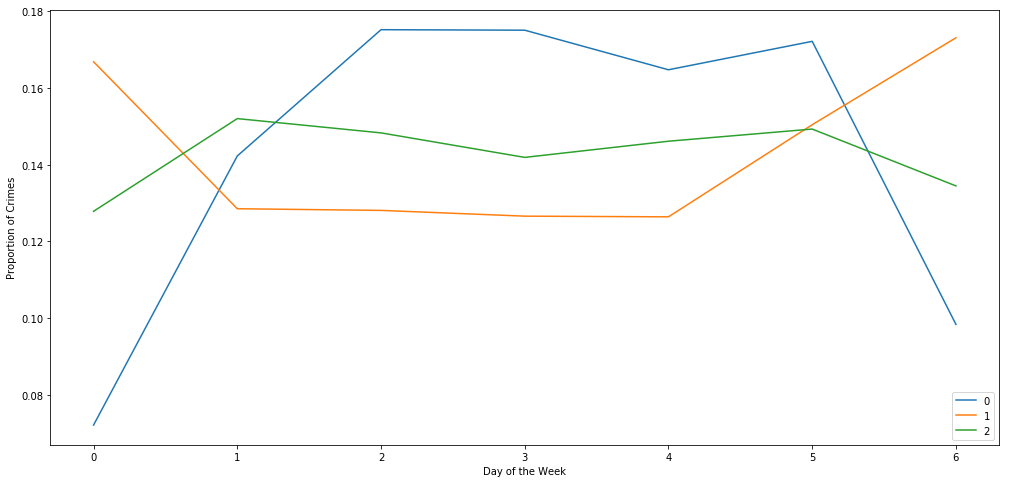

In [93]:
plt.figure(figsize = (17,8))
plt.plot(day_avg)
plt.xlabel('Day of the Week')
plt.ylabel('Proportion of Crimes')
plt.legend([0,1,2])
plt.show()

Cluster 0 crimes occur more often on weekdays, while cluster 1 occurs more often on weekends. Cluster 2 is generally more even, peaking slightly on Monday and Friday.

e) Do the three clusters affect different types of communities/neighborhoods?  To answer this question, you could first compute the proportions of "cluster 1", "cluster 2", and "cluster 3" crimes for each community area, and identify particular community areas with disproportionate amounts of a given cluster.  You can then use the provided file (HW3Q3_2.csv), to determine whether these community areas have any notable common characteristics (poverty, overcrowding, etc.).  You may also wish to consult the Chicago Community Areas map at https://en.wikipedia.org/wiki/Community_areas_in_Chicago. (5 pts)

In [95]:
km = KMeans(n_clusters=3)
X3 = data3.loc[:,'community_area_1':'community_area_77']
res3 = km.fit(X3)
data3_commclusters = pd.concat([data3,pd.Series(res3.predict(X3))],axis=1)
#res=pd.concat((data3,pd.Series(res)),axis=1)
data3_commclusters = data3_commclusters.rename(columns={0: "comm_cluster"})
#print('With',3,'clusters, sum of squared errors is',km.inertia_,'\n')

In [96]:
comm_avg = pd.DataFrame(res3.cluster_centers_).T
comm_avg.head()

,0,1,2
0,0.011178,0.017843,0.007551
1,0.010275,0.016167,0.001729
2,0.010847,0.019477,0.002579
3,0.005517,0.011656,0.000000
4,0.002760,0.008388,0.000000


In [132]:
comm_char = comm_avg.join(data4, how='outer')

In [134]:
comm_char.head()

,0,1,2,Community Area Number,COMMUNITY AREA NAME,centroid_x,centroid_y,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,PERCENT OF HOUSING UNITS VACANT,NUM_CRIMES_2016
0,0.011178,0.017843,0.007551,1,Rogers Park,1164399.219,1947666.815,7.7,23.6,8.7,18.2,27.5,23939,11.870556,3420
1,0.010275,0.016167,0.001729,2,West Ridge,1158307.200,1943243.722,7.8,17.2,8.8,20.8,38.5,23040,9.870385,3068
2,0.010847,0.019477,0.002579,3,Uptown,1168228.082,1930980.022,3.8,24.0,8.9,11.8,22.2,35787,8.672137,3330
3,0.005517,0.011656,0.000000,4,Lincoln Square,1159618.804,1933105.743,3.4,10.9,8.2,13.4,25.5,37524,8.600422,1859
4,0.002760,0.008388,0.000000,5,North Center,1161104.228,1924056.010,0.3,7.5,5.2,4.5,26.2,57123,10.100636,1280


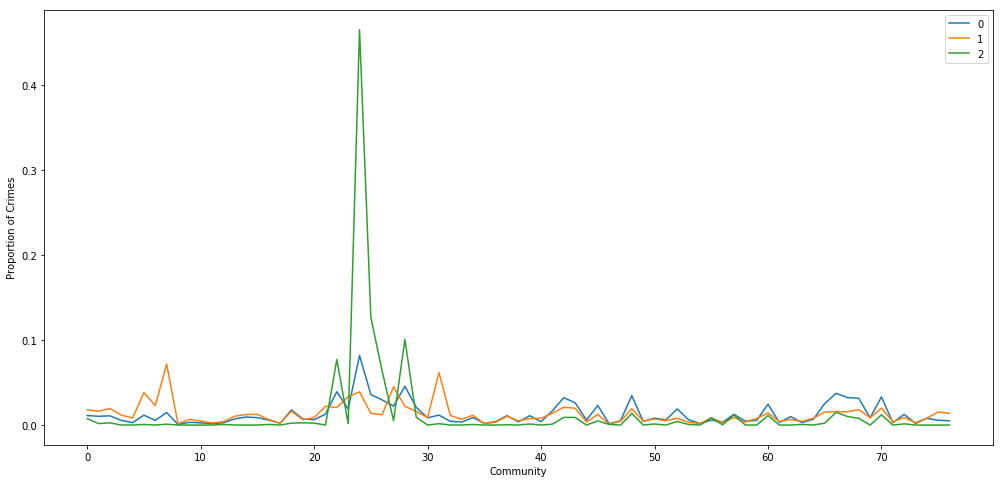

In [97]:
plt.figure(figsize = (17,8))
plt.plot(comm_avg)
plt.xlabel('Community')
plt.ylabel('Proportion of Crimes')
plt.legend([0,1,2])
plt.show()

Community number 24 has a high proportion of crimes.

f) How well do the three groups formed by clustering hour-of-day trends correspond to the FBI’s division between P1V, P1P, and P2 crimes? (5 pts)

In [102]:
data3_hrclusters[data3_hrclusters['hr_cluster'] == 0].groupby('Category').count()['crime_type']

Category
P1P     6
P1V    22
P2     25
Name: crime_type, dtype: int64

In [103]:
data3_hrclusters[data3_hrclusters['hr_cluster'] == 1].groupby('Category').count()['crime_type']

Category
P1P     9
P1V     2
P2     43
Name: crime_type, dtype: int64

In [104]:
data3_hrclusters[data3_hrclusters['hr_cluster'] == 2].groupby('Category').count()['crime_type']

Category
P2    12
Name: crime_type, dtype: int64

Cluster 0 is mainly split into the two FBI categories of P1V and P2. Cluster 1 is mainly grouped into category P2, while Cluster 2 most corresponds with the FBI's categories, as it is only classified as P2. 

g) For part g, you will use the same dataset to compare the clusters produced by several different methods.  But this time you should cluster using only the _day-of-week_ (not hour-of-day) attributes (day_Sun..day_Sat).  Please perform four different clusterings using (i) k-means, (ii) Gaussian mixture models, (iii) Bottom-up hierarchical clustering with "single link" distance metric, and (iv) Bottom-up hierarchical clustering with "complete link" distance metric.  In each case, you should choose the number of clusters using the silhouette method (or another established method of your choice- please specify).  For each clustering, report the number of clusters formed and the number of elements in each cluster. You should also identify any notable similarities or differences between the clusterings. (20 pts)

[1.1257498352328121, 0.9292259294720858, 0.7690824253359965, 0.7040363492937176, 0.6620746210364572, 0.6234397389439593, 0.5876706403869028, 0.555498949762521]


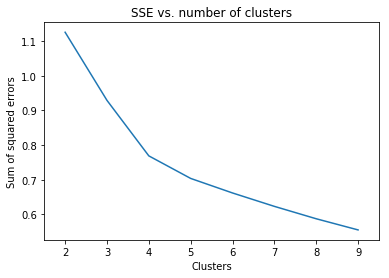

In [138]:
# (i)

# As an alternative, look for an elbow in the within-cluster SSE (k-means example):
SSE = []
for i in range(2,10):
    km = KMeans(n_clusters = i)
    res=km.fit(X)
    SSE.append(res.inertia_)
print SSE

plt.gca()
plt.plot(range(2,10),SSE)
plt.xlabel("Clusters")
plt.ylabel("Sum of squared errors")
plt.title("SSE vs. number of clusters")
plt.xlim(1.5,9.5)
plt.show()

Using the elbow method, the ideal number of clusters to use appears to be 4. 

In [125]:
# (ii)
# Use Gaussian mixture models (EM) package from sklearn
for i in range(2,10):
    gmm = GaussianMixture(n_components=i,random_state=100)
    res = gmm.fit(X)
    silhouette_avg = silhouette_score(X, res.predict(X))
    print("For n_clusters = {},".format(i)+" the average silhouette_score is : {}".format(silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.289602379571
For n_clusters = 3, the average silhouette_score is : 0.197754113493
For n_clusters = 4, the average silhouette_score is : 0.217724835687
For n_clusters = 5, the average silhouette_score is : 0.193353922541
For n_clusters = 6, the average silhouette_score is : 0.198618331461
For n_clusters = 7, the average silhouette_score is : 0.186640288061
For n_clusters = 8, the average silhouette_score is : 0.129690725452
For n_clusters = 9, the average silhouette_score is : 0.137814455121


Using the silhouette method, the ideal number of clusters to use appears to be 2. 

In [123]:
# (iii)

range_n_clusters = range(2,10)
Z = linkage(X, 'single')

for n_clusters in range_n_clusters:
    cluster_labels=fcluster(Z, n_clusters, criterion='maxclust')    
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.407716481215
For n_clusters = 3, the average silhouette_score is : 0.351120617092
For n_clusters = 4, the average silhouette_score is : 0.25177238984
For n_clusters = 5, the average silhouette_score is : 0.175227832819
For n_clusters = 6, the average silhouette_score is : 0.0966887754148
For n_clusters = 7, the average silhouette_score is : 0.0488479594934
For n_clusters = 8, the average silhouette_score is : 0.0179208518765
For n_clusters = 9, the average silhouette_score is : 0.000739623397293


Using the silhouette method, the ideal number of clusters to use appears to be 2, the same result as the guassian mixture clustering.

In [124]:
# (iv)

# Choose a range of cluster numbers that you would like to evalulate:
range_n_clusters = range(2,10)
Z = linkage(X, 'complete')

for n_clusters in range_n_clusters:
    cluster_labels=fcluster(Z, n_clusters, criterion='maxclust')    
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.15452891314
For n_clusters = 3, the average silhouette_score is : 0.172863719374
For n_clusters = 4, the average silhouette_score is : 0.191058141652
For n_clusters = 5, the average silhouette_score is : 0.189262261404
For n_clusters = 6, the average silhouette_score is : 0.162321413952
For n_clusters = 7, the average silhouette_score is : 0.155112243886
For n_clusters = 8, the average silhouette_score is : 0.15552352256
For n_clusters = 9, the average silhouette_score is : 0.1352430999


Using the silhouette method, the ideal number of clusters to use appears to be 4, the same result as the K Means clustering.